# Assignment 3: Text Classification With Neural Networks
### Submitted by: Shivani Naik

The task is to build a text classifier with machine learning models and neural networks. 

Dataset: https://www.kaggle.com/datasets/matleonard/nlp-course?select=spam.csv

References:
1. https://towardsdatascience.com/text-classification-on-disaster-tweets-with-lstm-and-word-embedding-df35f039c1db
2. https://fasttext.cc/docs/en/english-vectors.html

In [ ]:
!pip install scikit-plot
!pip install fasttext

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import  WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import scikitplot as skplt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Bidirectional
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from gensim.models.keyedvectors import KeyedVectors
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from keras.layers.pooling import GlobalAveragePooling1D
import logging
from numpy import array
from numpy import asarray
from numpy import zeros
import fasttext


%matplotlib inline

In [ ]:
# Download nltk packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [2]:
df = pd.read_csv("spam.csv")

In [24]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 1. Bag Of Words

## Machine Learning Pipeline Class and EDA

I have included all the functions for preprocessing and training different models in a class.

In [25]:
class Pipeline():
  def __init__(self):
    pass
  def toLower(self, x):
    '''Converts string to lowercase'''
    return x.lower()
  
  def sentenceTokenize(self, x):
    '''Tokenizes document into sentences'''
    sent_tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
    sentences = sent_tokenizer.tokenize(x)
    return sentences
  
  def preprocess_sentences(self, text):
    '''Tokenizes sentences into words, removes punctuations, stopwords and 
    performs tokenization'''
    word_tokenizer = nltk.RegexpTokenizer(r"\w+")
    special_characters = re.compile("[^A-Za-z0-9 ]")
    # remove punctuation
    s = re.sub(special_characters, " ", text)
    # Word tokenize
    words = word_tokenizer.tokenize(s)
    # Remove Stopwords
    words = self.removeStopwords(words)
    # Perform lemmatization
    words = self.wordnet_lemmatize(words)
    return words


  def removeStopwords(self, sentence):
    '''Removes stopwords from a sentence'''
    stop_words = stopwords.words('english')
    tokens = [token for token in sentence if token not in stop_words]
    return tokens

  def wordnet_lemmatize(self, sentence):
    '''Lemmatizes tokens in a sentence'''
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in sentence]
    return tokens

  
  def complete_preprocess(self, text):
    '''Performs complete preprocessing on document'''
    #Convert text to lowercase
    text_lower = self.toLower(text)
    #Preprocess all sentences
    preprocessed_sentences = self.preprocess_sentences(text_lower)
    return preprocessed_sentences


  def generate_wordcloud(self, text):
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    plt.figure(figsize=(15,8))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

  def create_bow(self, df, col, max_features = 20000):
    df['text_final'] = df[col].apply(lambda x: ' '.join(x))
    X = df['text_final']
    y = df['label']
    
    le = LabelEncoder()
    y = le.fit_transform(y)
    # Create bag of words using count vectorizer
    cnt_vec = CountVectorizer(analyzer="word", max_features = max_features) #try tuning
    X_bow = cnt_vec.fit_transform(X)
    
    return(cnt_vec, X_bow, y, le)

  
  def train_evaluate_model(self, model, X_train, X_test, y_train, y_test):
    '''Train and evaluate specified model, function can be reused with different models'''
    model.fit(X_train, y_train)
    pred_test  = model.predict(X_test)
    pred_train = model.predict(X_train)
    prob_test  = model.predict_proba(X_test)
    prob_train = model.predict_proba(X_train)
    train_acc = accuracy_score(y_train, pred_train)
    test_acc  = accuracy_score(y_test, pred_test)
    train_auc_score = roc_auc_score(y_train, prob_train[:,1])
    test_auc_score = roc_auc_score(y_test, prob_test[:,1])
    class_report = classification_report(y_test, pred_test)

    print ("Model ROC-AUC score for training sample: %.3f" \
                                      % train_auc_score)
    print ("Model ROC-AUC score for test sample: %.3f" \
                                      % test_auc_score)
    print ("Train Accuracy: ", train_acc)
    print ("Test Accuracy: ", test_acc)
    print ("Classification report: \n", class_report)
    skplt.metrics.plot_confusion_matrix(y_test, pred_test, title="Confusion Matrix",
                text_fontsize='large')
    plt.show()
    return(model)

  def hyperparameter_tuning(self, model, param_grid, X_train, y_train, cv = 5):
        
        optimal_model = GridSearchCV(
            estimator = model,
            param_grid=param_grid,
            n_jobs = -1,
            cv = cv,
            scoring = 'accuracy',
            verbose=2
        )
        optimal_model.fit(X_train, y_train)
        print(optimal_model.best_score_)
        print(optimal_model.best_params_)
        return(optimal_model.best_estimator_)

In [26]:
# Instantiate Pipeline
pipeline = Pipeline()

We have an imbalanced dataset, with only 13% data as spam. So we need to consider metrics that take these into account, as well as stratified splitting.

In [27]:
df['label'].value_counts(normalize = True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [28]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


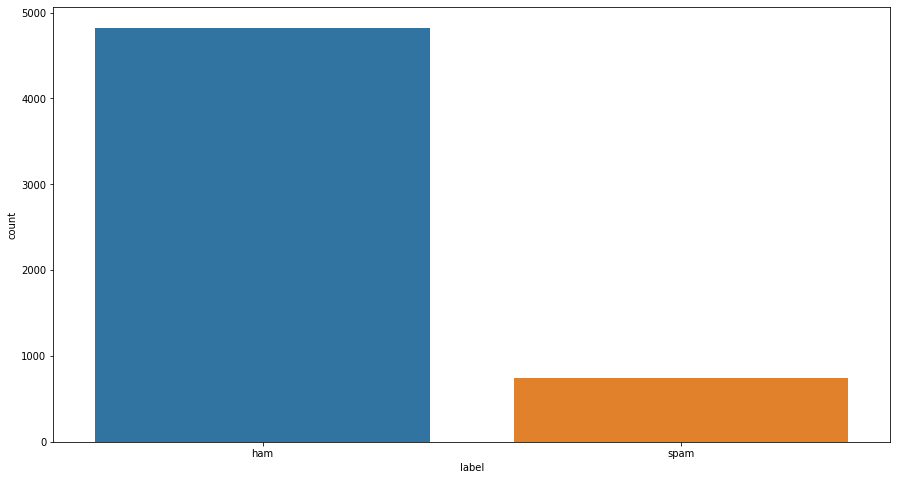

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(df['label'])

In [31]:
df["clean_text"] = df['text'].apply(lambda x: pipeline.complete_preprocess(x))


In [ ]:
df.head()

,label,text,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, think, go, usf, live, around, though]"
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,"[2nd, time, try, 2, contact, u, u, 750, pound,..."
5568,ham,Will Ì_ b going to esplanade fr home?,"[b, go, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...","[pity, mood, suggestions]"
5570,ham,The guy did some bitching but I acted like i'd...,"[guy, bitch, act, like, interest, buy, somethi..."


In [32]:
cnt_vec, X_bow, y, le = pipeline.create_bow(df, 'clean_text')
cnt_vec, X_bow.shape

(CountVectorizer(max_features=20000), (5572, 7524))

In [33]:
df.head()

,label,text,clean_text,text_final
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, u, oni]",ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]",u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, think, go, usf, live, around, though]",nah think go usf live around though


In [ ]:
ham_text = ' '.join(df[df['label'] == 'ham']['text_final'])
spam_text = ' '.join(df[df['label'] == 'spam']['text_final'])

# Wordcloud
Wordclouds indicate most words used for spam are "call, free, mobile, award, cash, text".
Whereas for not spam, it has words like "think, tell, come, love, ok" etc

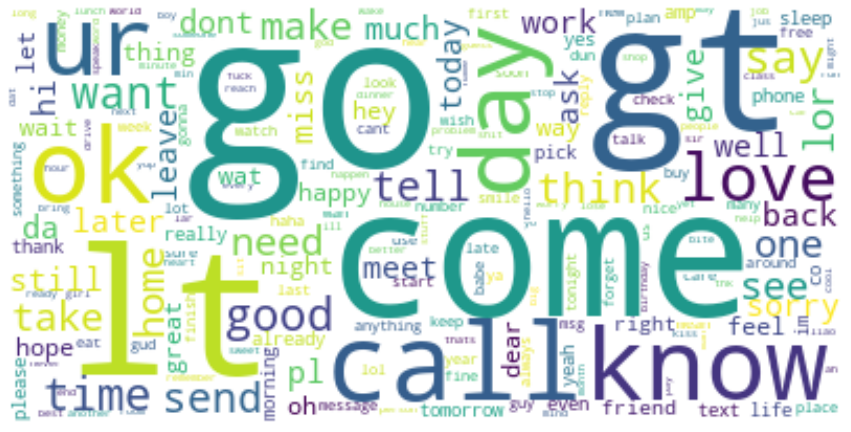

In [ ]:
pipeline.generate_wordcloud(ham_text)

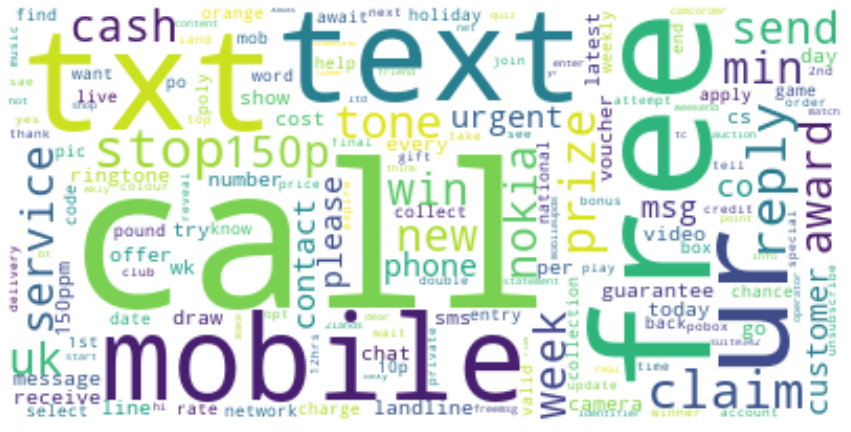

In [ ]:
pipeline.generate_wordcloud(spam_text)

In [ ]:
le.classes_

array(['ham', 'spam'], dtype=object)

In [ ]:
#stratified train test split to maintain ratio of classes
X_train, X_test, y_train, y_test = train_test_split(X_bow.toarray(), y, 
                                                    test_size=0.3, random_state=100,
                                                    stratify = y)
print ("Number of spam in training set: " , y_train.sum())
print ("Number of spam in test set: ",y_test.sum())

print ("Ratio of spam in training set: " , round(y_train.sum()/len(y_train),2))
print ("Ratio of spam in testing data set: ", round(y_test.sum()/len(y_test),2))

Number of spam in training set:  523
Number of spam in test set:  224
Ratio of spam in training set:  0.13
Ratio of spam in testing data set:  0.13


## Decision Tree Classifier


Model ROC-AUC score for training sample: 1.000
Model ROC-AUC score for test sample: 0.932
Train Accuracy:  1.0
Test Accuracy:  0.9700956937799043
Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1448
           1       0.90      0.88      0.89       224

    accuracy                           0.97      1672
   macro avg       0.94      0.93      0.94      1672
weighted avg       0.97      0.97      0.97      1672



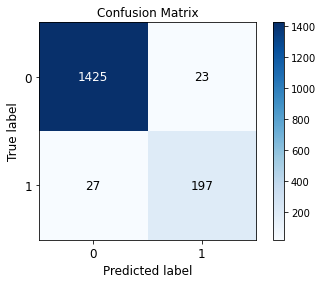

In [ ]:
dt = pipeline.train_evaluate_model(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

## Naive Bayes

Model ROC-AUC score for training sample: 0.997
Model ROC-AUC score for test sample: 0.982
Train Accuracy:  0.9930769230769231
Test Accuracy:  0.9808612440191388
Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1448
           1       0.93      0.93      0.93       224

    accuracy                           0.98      1672
   macro avg       0.96      0.96      0.96      1672
weighted avg       0.98      0.98      0.98      1672



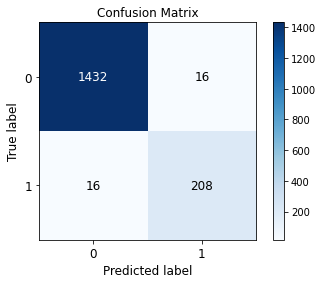

In [ ]:
nb = pipeline.train_evaluate_model(MultinomialNB(), X_train, X_test, y_train, y_test)

## Logistic Regression

Model ROC-AUC score for training sample: 1.000
Model ROC-AUC score for test sample: 0.987
Train Accuracy:  0.9961538461538462
Test Accuracy:  0.9838516746411483
Classification report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       0.99      0.88      0.94       224

    accuracy                           0.98      1672
   macro avg       0.99      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672



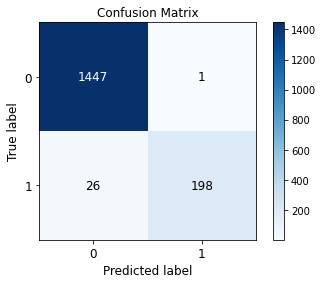

In [ ]:
lr = pipeline.train_evaluate_model(LogisticRegression(), X_train, X_test, y_train, y_test)

## Random Forest Classifier

Model ROC-AUC score for training sample: 1.000
Model ROC-AUC score for test sample: 0.995
Train Accuracy:  1.0
Test Accuracy:  0.9796650717703349
Classification report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       1.00      0.85      0.92       224

    accuracy                           0.98      1672
   macro avg       0.99      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672



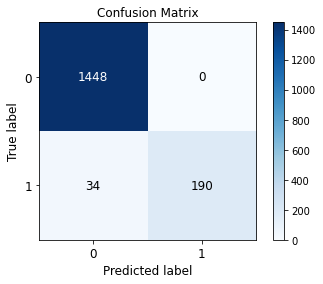

In [ ]:
rf = pipeline.train_evaluate_model(RandomForestClassifier(), X_train, X_test, y_train, y_test)

## Gradient Boosting Classifier

Model ROC-AUC score for training sample: 0.999
Model ROC-AUC score for test sample: 0.979
Train Accuracy:  0.9797435897435898
Test Accuracy:  0.9694976076555024
Classification report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1448
           1       0.96      0.80      0.88       224

    accuracy                           0.97      1672
   macro avg       0.97      0.90      0.93      1672
weighted avg       0.97      0.97      0.97      1672



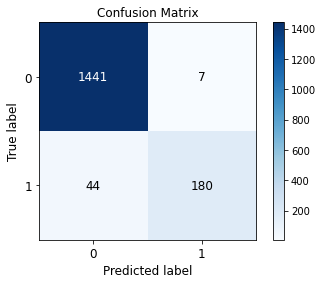

In [ ]:
gb = pipeline.train_evaluate_model(GradientBoostingClassifier(), X_train, X_test, y_train, y_test)

Logistic Regression performs the best as it has overall good accuracy, and misclassifies less not spam as spam, which is the desired behavior because we do not want to label an important message as spam.

# 2. Deep Learning Models

Following neural network models have been trained with different embeddings:
* GloVe Embeddings
  * Vanilla Neural Network
  * LSTM
  * BiLSTM
  * BiLSTM with Attention
* FastText Embeddings
  * Vanilla Neural Network
  * LSTM
  * BiLSTM
  * BiLSTM with Attention
* Word2Vec Embeddings
  * Vanilla Neural Network
  * LSTM
  * BiLSTM
  * BiLSTM with Attention

In [6]:
# Mount data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Since there is no Keras wrapper for Attention layer, I have used a custom Attention class.

Reference: https://machinelearningmastery.com/adding-a-custom-attention-layer-to-recurrent-neural-network-in-keras/


In [3]:
# Custom Attention Layer
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        e = K.squeeze(e, axis=-1)   
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

## Deep Learning Pipeline Class

I have included all the functions for preprocessing and training different neural networks in a class.

In [4]:
class DLPipeline():
  def __init__(self):
    pass
  def preprocess(self, text):
    '''Preprocesses text, removes punctuation and extra spaces'''
    special_characters = re.compile("[^A-Za-z0-9 ]")
    # remove punctuation
    s = re.sub(special_characters, " ", text)
    s = re.sub(r"\s+[a-zA-Z]\s+", ' ', s)
    s = re.sub(r'\s+', ' ', s)
    return s

  def tokenize(self, X_train, X_test):
    '''Tokenize text in format required by Keras models'''
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    # Convert text to token sequences
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    # Vocab size plus 1 because 0 index is reserved
    vocab_size = len(tokenizer.word_index) + 1
    return (X_train, X_test, tokenizer, vocab_size)
  
  def create_padding(self, X_train, X_test, maxlen = 100):
    '''Pads input sentences to length maxlen'''
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen) 
    return (X_train, X_test)

  def load_glove_embedding_dictionary(self, root, glove_file_name = 'glove.6B.100d.txt'):
    '''Loads pretrained Glove vectors from downloaded file'''
    glove_embeddings_dict = dict()
    glove_file = open(root + glove_file_name, encoding="utf8")
    for line in glove_file:
        records = line.split()
        word = records[0]
        word_vector = asarray(records[1:], dtype='float32')
        glove_embeddings_dict[word] = word_vector
    glove_file.close()
    return glove_embeddings_dict

  def load_fasttext_embedding_dictionary(self, root, filename):
    ft = fasttext.load_model(root+filename)
    return ft

  def create_glove_embedding_matrix(self, tokenizer, embeddings_dict, vocab_size, embedding_dim = 100):
    '''Creates Embedding matrix from pretrained Glove vectors'''
    # Create an empty embedding matrix of dimensions vocab_size x embedding_dim
    # Each row corresponds to embedding of a word in the vocab
    embedding_matrix = zeros((vocab_size, embedding_dim)) 
    # retrieve pretrained Glove embedding for all words of our vocab
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix

  def load_w2vec_embedding_dictionary(self, root, w2vec_file_name = 'GoogleNews-vectors-negative300.bin'):
    '''Loads pretrained Word2vec vectors from downloaded file'''
    w2vec_file_name = root + w2vec_file_name
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    print("Loading word2vec model")
    word2vec_model = KeyedVectors.load_word2vec_format(w2vec_file_name, binary=True)
    return word2vec_model

  def create_embedding_matrix(self, tokenizer, w2vec_embeddings_dict, vocab_size, embedding_dim):
    '''Creates Embedding matrix from pretrained Word2Vec vectors'''
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
      if word in w2vec_embeddings_dict:
        embedding_vector = w2vec_embeddings_dict[word]
      else:
        embedding_vector = None
      if embedding_vector is not None:  
        embedding_matrix[i] = embedding_vector
    return embedding_matrix

  def plot_accuracy_loss(self, history):
    '''Creates loss and accuracy plot of training and validation from training history'''
    # Plot accuracy
    plt.figure(figsize = (15,8))
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.show()

    # Plot loss
    plt.figure(figsize = (15,8))
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()

  def create_simple_nn_model(self, embedding_matrix, vocab_size, maxlen, embedding_dim):
    '''Create a vanilla neural network model'''
    model = Sequential()
    # Create embedding layer, with non trainable parameters 
    embedding_layer = Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim, 
                                weights=[embedding_matrix], 
                                input_length=maxlen , 
                                trainable=False)
    model.add(embedding_layer)
    # Add a flatten layer
    model.add(Flatten())
    # Add the final Dense layer for classification
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

  def create_globalavg_nn_model(self, embedding_matrix, vocab_size, maxlen, embedding_dim):
    '''Create a vanilla neural network model with Global average pooling instead of Flatten'''
    model = Sequential()
    embedding_layer = Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim, 
                                weights=[embedding_matrix], 
                                input_length=maxlen , 
                                trainable=False)
    model.add(embedding_layer)
    # Add a flatten layer
    model.add(GlobalAveragePooling1D())
    # Add the final Dense layer for classification
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

  def create_LSTM_nn_model(self, embedding_matrix, vocab_size, maxlen, embedding_dim, trainable = False):
    '''Creates an LSTM model with given parameters'''
    model = Sequential()
    # Create embedding layer, with non trainable parameters 
    embedding_layer = Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim, 
                                weights=[embedding_matrix], 
                                input_length=maxlen , 
                                trainable=trainable)
    model.add(embedding_layer)
    # Add a LSTM layer
    model.add(LSTM(128))
    # Add the final Dense layer for classification
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

  def create_BiLSTM_nn_model(self, embedding_matrix, vocab_size, maxlen, embedding_dim):
    '''Creates an BiLSTM model with given parameters'''
    model = Sequential()
    # Create embedding layer, with non trainable parameters 
    embedding_layer = Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim, 
                                weights=[embedding_matrix], 
                                input_length=maxlen , 
                                trainable=False)
    model.add(embedding_layer)
    # Add a BiLSTM layer
    model.add(Bidirectional(LSTM(128)))
    # Add the final Dense layer for classification
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model
  

  def create_BiLSTM_Attention_nn_model(self, lstm_units, embedding_matrix, vocab_size, max_len, embedding_dim):
    '''Creates an BiLSTM model with Attention and given parameters'''
    x=Input(shape=(max_len,))
    # Create embedding layer, with non trainable parameters 
    embedding_layer = Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim, 
                                weights=[embedding_matrix], 
                                input_length=max_len , 
                                trainable=False)(x)
    # Add a BiLSTM layer                            
    lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)
    # Add an Attention layer 
    attention_layer = attention()(lstm_layer)
    # Add the final Dense layer for classification
    outputs=Dense(1, trainable=True, activation='sigmoid')(attention_layer)
    model = Model(x,outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model   

  def train_evaluate_model(self, model, X_train, y_train, X_test, y_test, 
                         epochs = 10, batch_size = 128):
    '''Trains and evaluates a model'''
    history = model.fit(X_train, 
                        y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        verbose=1, 
                        validation_split=0.2)
    score = model.evaluate(X_test, y_test, verbose=1)
    print("Test loss, Test Accuracy: ", score)
    return history
  
  def evaluate_model(self, model, X_test, y_test):
    '''Evaluates a model with different metrics'''
    y_pred = model.predict(X_test, verbose=1, batch_size=64)
    y_pred_bool = [1 * (x[0]>=0.5) for x in y_pred]
    test_auc_score = roc_auc_score(y_test, y_pred)
    print(classification_report(y_test, y_pred_bool))
    print("Model ROC-AUC score for test sample: %.3f" \
                                        % test_auc_score)
    skplt.metrics.plot_confusion_matrix(y_test, y_pred_bool, title="Confusion Matrix",
                  text_fontsize='large')
    plt.show()



In [5]:
# Instantiate DL Pipeline
dl_pipeline = DLPipeline()

### Data Preprocessing
We will preprocess the data and label encode the target variable.

In [6]:
X = list(df['text'].apply(lambda x: dl_pipeline.preprocess(x)))
# Encode the y variable
le = LabelEncoder()
y = le.fit_transform(df['label'])
y

array([0, 0, 1, ..., 0, 0, 0])

In [7]:
len(X), y.shape

(5572, (5572,))

### Train Test Split
I have created a stratified train test split of 80-20 % to take care of class imbalance.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)

### Tokenize Data
Let us tokenize the data in the format required by Keras models.

In [9]:
X_train, X_test, tokenizer, vocab_size = dl_pipeline.tokenize(X_train, X_test)
len(X_train), len(tokenizer.word_index)

(4457, 7688)

###Padding Data
We will pad the data to max_len, to make all sentences of the same length for inputting to the neural networks.

In [10]:
max_len = 100
X_train, X_test = dl_pipeline.create_padding(X_train, X_test, max_len)
X_train.shape, X_test.shape

((4457, 100), (1115, 100))

# Neural Networks with Glove Embeddings
I have trained 4 models with pre trained Glove Embeddings:

* Simple Neural Network
* LSTM
* BiLSTM
* BiLSTM with Attention



### Loading Glove Vectors

Let us load the pretrained Glove embeddings in a dictionary.

In [55]:
root = "/content/drive/MyDrive/"
glove_file_name = 'glove.6B.100d.txt'

glove_embeddings_dict = dl_pipeline.load_glove_embedding_dictionary(root, glove_file_name)

### Creating Embedding Matrix
We will create an embedding matrix from the GloVe vectors that will be used as weights in the embedding layer of our neural networks. The embedding dimension for Glove vectors is 100.

In [56]:
embedding_dim = 100
embedding_matrix = dl_pipeline.create_glove_embedding_matrix(tokenizer, glove_embeddings_dict, vocab_size, embedding_dim)

embedding_matrix.shape

(7689, 100)

## Neural Network
Let us create a simple neural network model with only embedding layer and flatten layer, with the embeddings from Glove.

In [57]:
nn_model = dl_pipeline.create_simple_nn_model(embedding_matrix, vocab_size, max_len,embedding_dim)

In [58]:
nn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          768900    
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_7 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 778,901
Trainable params: 10,001
Non-trainable params: 768,900
_________________________________________________________________


### Train model
I have experimented with different hyperparameters:
* epochs
*batch_size

In [59]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(nn_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
28/28 [==============================] - 1s 17ms/step - loss: 0.3649 - acc: 0.8766 - val_loss: 0.2586 - val_acc: 0.9070
Epoch 2/20
28/28 [==============================] - 0s 6ms/step - loss: 0.1958 - acc: 0.9397 - val_loss: 0.1941 - val_acc: 0.9361
Epoch 3/20
28/28 [==============================] - 0s 6ms/step - loss: 0.1493 - acc: 0.9619 - val_loss: 0.1672 - val_acc: 0.9484
Epoch 4/20
28/28 [==============================] - 0s 6ms/step - loss: 0.1249 - acc: 0.9691 - val_loss: 0.1503 - val_acc: 0.9574
Epoch 5/20
28/28 [==============================] - 0s 8ms/step - loss: 0.1091 - acc: 0.9739 - val_loss: 0.1398 - val_acc: 0.9574
Epoch 6/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0974 - acc: 0.9767 - val_loss: 0.1297 - val_acc: 0.9641
Epoch 7/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0882 - acc: 0.9781 - val_loss: 0.1211 - val_acc: 0.9686
Epoch 8/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0802 - acc: 0.9

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score
*AUC ROC Score

18/18 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       966
           1       0.94      0.85      0.89       149

    accuracy                           0.97      1115
   macro avg       0.96      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Model ROC-AUC score for test sample: 0.982


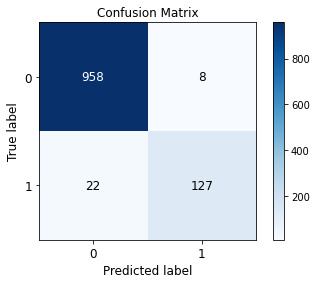

In [60]:
dl_pipeline.evaluate_model(nn_model, X_test, y_test)

### Plot Accuracy and Loss

There is a steep increase in accuracy after 2-3 epochs


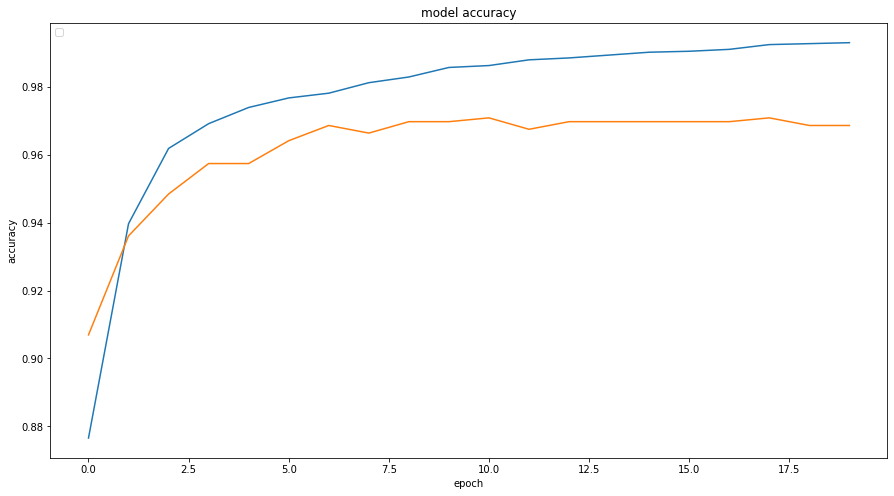

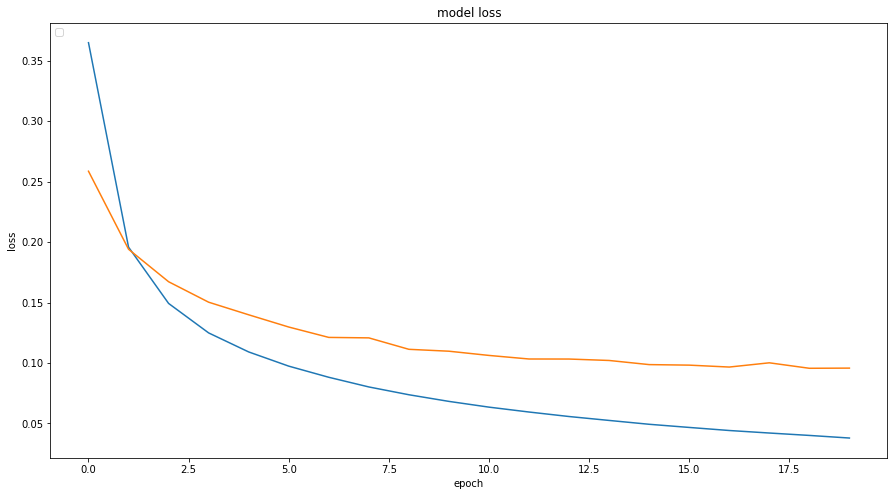

In [61]:
dl_pipeline.plot_accuracy_loss(history)

## LSTM
Let us create an LSTM model with the embeddings from Glove.

In [67]:
lstm_model = dl_pipeline.create_LSTM_nn_model(embedding_matrix, vocab_size, max_len, embedding_dim)

In [68]:
lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          768900    
                                                                 
 lstm_7 (LSTM)               (None, 128)               117248    
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 886,277
Trainable params: 117,377
Non-trainable params: 768,900
_________________________________________________________________


### Train model
I have experimented with different hyperparameters:
* epochs
*batch_size
* Number of hidden units

In [69]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(lstm_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
28/28 [==============================] - 2s 31ms/step - loss: 0.4714 - acc: 0.8738 - val_loss: 0.2459 - val_acc: 0.9070
Epoch 2/20
28/28 [==============================] - 0s 12ms/step - loss: 0.2251 - acc: 0.9408 - val_loss: 0.1954 - val_acc: 0.9529
Epoch 3/20
28/28 [==============================] - 0s 12ms/step - loss: 0.1391 - acc: 0.9599 - val_loss: 0.1691 - val_acc: 0.9406
Epoch 4/20
28/28 [==============================] - 0s 12ms/step - loss: 0.1431 - acc: 0.9560 - val_loss: 0.1485 - val_acc: 0.9608
Epoch 5/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1314 - acc: 0.9649 - val_loss: 0.1358 - val_acc: 0.9720
Epoch 6/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1080 - acc: 0.9731 - val_loss: 0.1492 - val_acc: 0.9552
Epoch 7/20
28/28 [==============================] - 0s 12ms/step - loss: 0.1069 - acc: 0.9717 - val_loss: 0.2304 - val_acc: 0.9496
Epoch 8/20
28/28 [==============================] - 0s 12ms/step - loss: 0.1738 - a

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score
*AUC ROC Score

18/18 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.92      0.93      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Model ROC-AUC score for test sample: 0.988


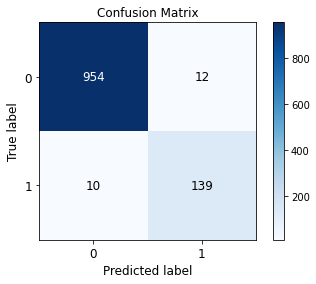

In [70]:
dl_pipeline.evaluate_model(lstm_model, X_test, y_test)

### Plot Accuracy and Loss


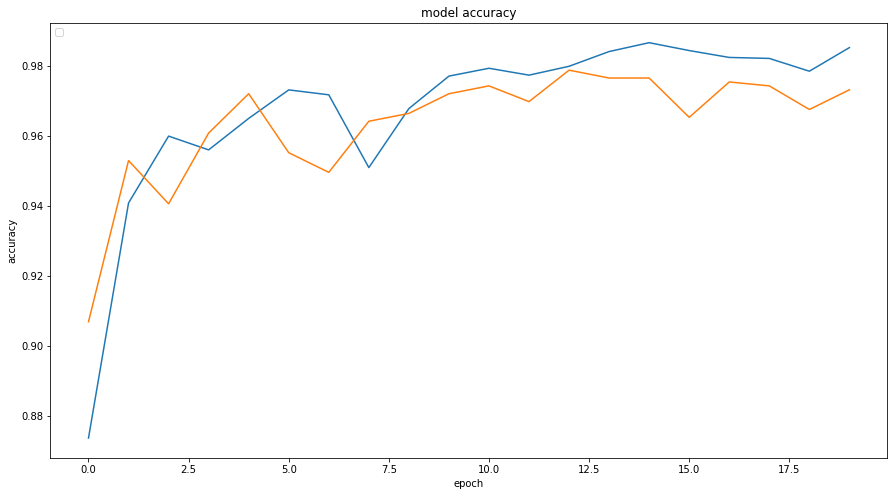

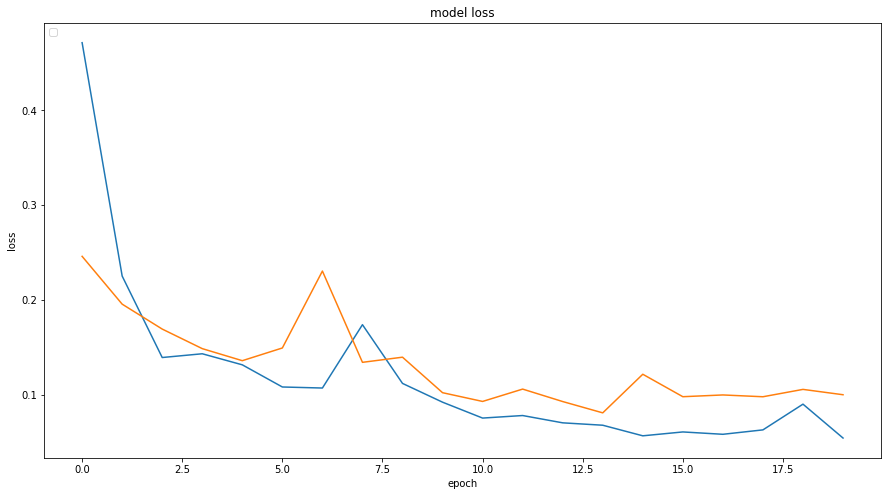

In [71]:
dl_pipeline.plot_accuracy_loss(history)

## BiLSTM
Let us create a BiLSTM model with the embeddings from Glove.

In [79]:
bilstm_model = dl_pipeline.create_BiLSTM_nn_model(embedding_matrix, vocab_size, max_len, embedding_dim)

In [80]:
bilstm_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 100)          768900    
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,003,653
Trainable params: 234,753
Non-trainable params: 768,900
_________________________________________________________________


### Train model
I have experimented with different hyperparameters:
* epochs
*batch_size
* Number of hidden units

In [81]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(bilstm_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
28/28 [==============================] - 4s 50ms/step - loss: 0.3648 - acc: 0.8508 - val_loss: 0.2525 - val_acc: 0.8924
Epoch 2/20
28/28 [==============================] - 0s 17ms/step - loss: 0.1442 - acc: 0.9532 - val_loss: 0.1415 - val_acc: 0.9473
Epoch 3/20
28/28 [==============================] - 0s 18ms/step - loss: 0.0954 - acc: 0.9728 - val_loss: 0.0934 - val_acc: 0.9709
Epoch 4/20
28/28 [==============================] - 0s 18ms/step - loss: 0.0755 - acc: 0.9773 - val_loss: 0.0854 - val_acc: 0.9720
Epoch 5/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0631 - acc: 0.9818 - val_loss: 0.0726 - val_acc: 0.9753
Epoch 6/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0589 - acc: 0.9829 - val_loss: 0.0848 - val_acc: 0.9686
Epoch 7/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0478 - acc: 0.9857 - val_loss: 0.0734 - val_acc: 0.9765
Epoch 8/20
28/28 [==============================] - 1s 23ms/step - loss: 0.0524 - a

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score
*AUC ROC Score

18/18 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.95      0.93      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Model ROC-AUC score for test sample: 0.992


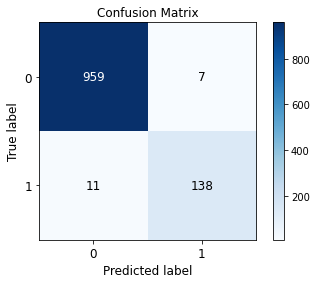

In [82]:
dl_pipeline.evaluate_model(bilstm_model, X_test, y_test)

### Plot Accuracy and Loss


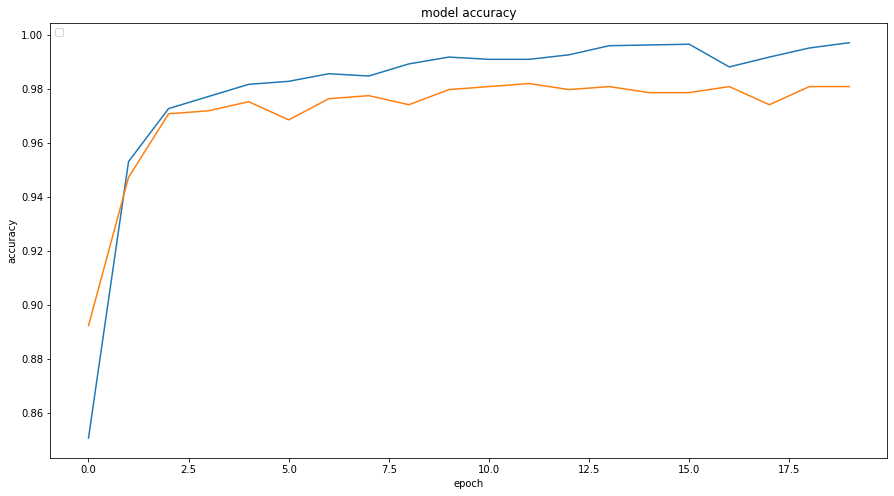

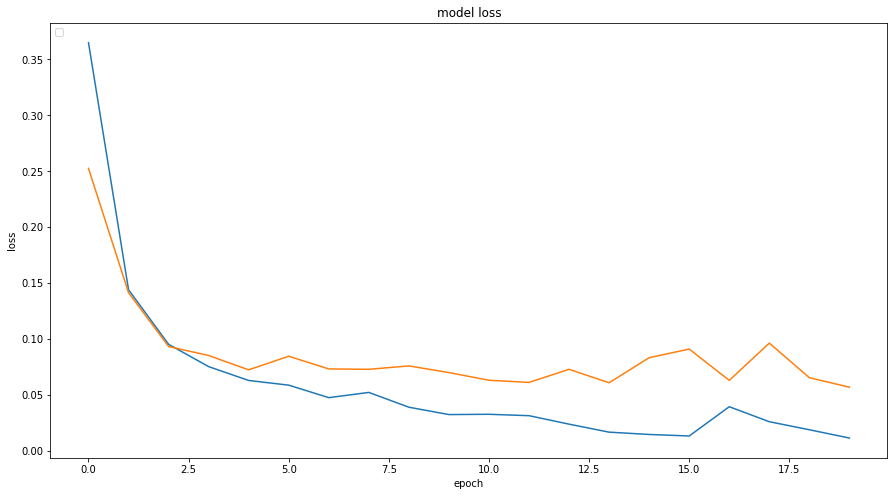

In [84]:
dl_pipeline.plot_accuracy_loss(history)

## BiLSTM with Attention
Let us create a BiLSTM model with Attention layer and the embeddings from Glove.

In [85]:
lstm_units = 128
bilstm_attention_model = dl_pipeline.create_BiLSTM_Attention_nn_model(lstm_units, embedding_matrix, vocab_size, max_len, embedding_dim)

In [86]:
bilstm_attention_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_12 (Embedding)    (None, 100, 100)          768900    
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 256)         234496    
 nal)                                                            
                                                                 
 attention_1 (attention)     (None, 256)               356       
                                                                 
 dense_12 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,004,009
Trainable params: 235,109
Non-trainable params: 768,900
_____________________________________________

### Train model
I have experimented with different hyperparameters:
* epochs
*batch_size
* Number of hidden units

In [87]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(bilstm_attention_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
28/28 [==============================] - 7s 51ms/step - loss: 0.4556 - acc: 0.8463 - val_loss: 0.3614 - val_acc: 0.8453
Epoch 2/20
28/28 [==============================] - 1s 19ms/step - loss: 0.1561 - acc: 0.9481 - val_loss: 0.1078 - val_acc: 0.9630
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.1129 - acc: 0.9582 - val_loss: 0.1383 - val_acc: 0.9608
Epoch 4/20
28/28 [==============================] - 1s 19ms/step - loss: 0.1080 - acc: 0.9633 - val_loss: 0.0948 - val_acc: 0.9731
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0811 - acc: 0.9717 - val_loss: 0.0910 - val_acc: 0.9686
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0657 - acc: 0.9781 - val_loss: 0.0815 - val_acc: 0.9720
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0617 - acc: 0.9790 - val_loss: 0.0984 - val_acc: 0.9652
Epoch 8/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0610 - a

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score
*AUC ROC Score

18/18 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Model ROC-AUC score for test sample: 0.986


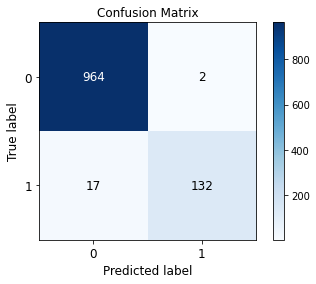

In [88]:
dl_pipeline.evaluate_model(bilstm_attention_model, X_test, y_test)

### Plot Accuracy and Loss


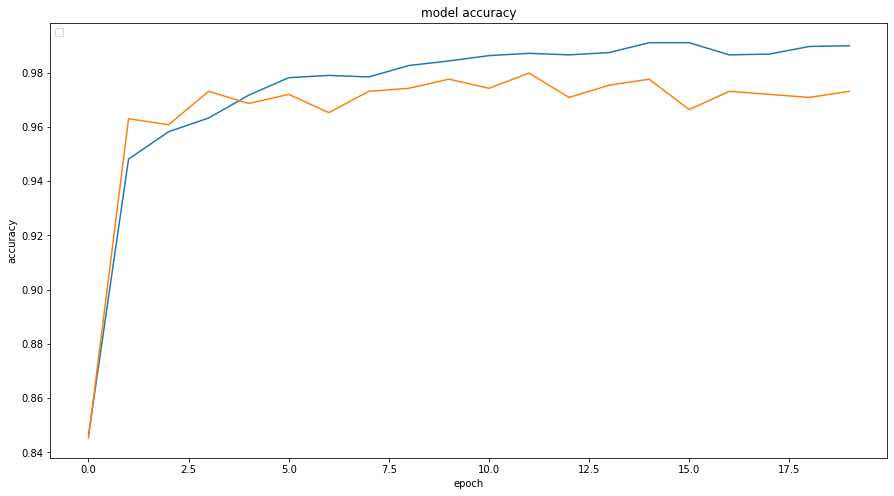

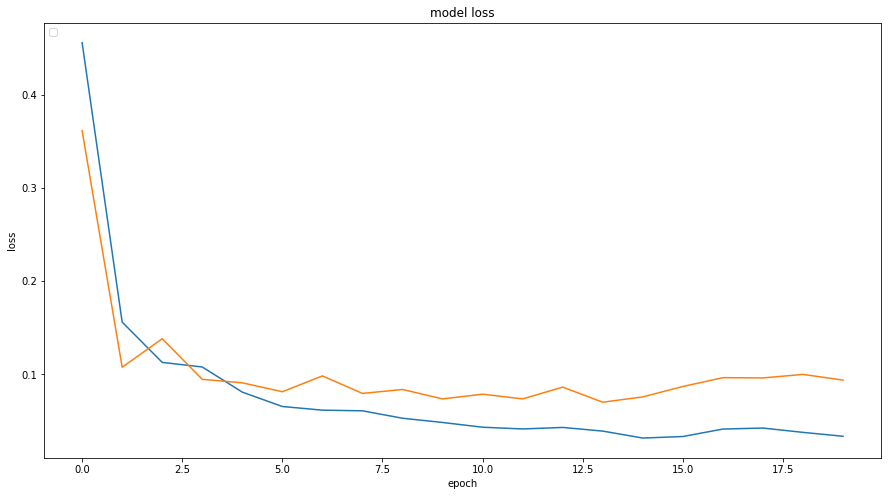

In [89]:
dl_pipeline.plot_accuracy_loss(history)

# Simple Neural Network with FastText

### Loading FastText Vectors

Let us load the pretrained FastText embeddings in a dictionary.

In [13]:
root = "/content/drive/MyDrive/"
fasttext_file_name = 'cc.en.300.bin'

fasttext_embedding_dict = dl_pipeline.load_fasttext_embedding_dictionary(root, fasttext_file_name)

### Creating Embedding Matrix
We will create an embedding matrix from the FastText vectors that will be used as weights in the embedding layer of our neural networks.

In [14]:
embedding_dim = 300
embedding_matrix = dl_pipeline.create_embedding_matrix(tokenizer, fasttext_embedding_dict, vocab_size, embedding_dim)

### Neural Network
Let us create a simple neural network model with the embeddings from Fasttext.

In [15]:
embedding_dim = 300
lstm_units = 128
fasttext_nn_model = dl_pipeline.create_simple_nn_model(embedding_matrix, vocab_size, max_len, embedding_dim)

In [16]:
fasttext_nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          2306700   
                                                                 
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 1)                 30001     
                                                                 
Total params: 2,336,701
Trainable params: 30,001
Non-trainable params: 2,306,700
_________________________________________________________________


In [17]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(fasttext_nn_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
28/28 [==============================] - 3s 9ms/step - loss: 0.4587 - acc: 0.8637 - val_loss: 0.3524 - val_acc: 0.8666
Epoch 2/20
28/28 [==============================] - 0s 4ms/step - loss: 0.2642 - acc: 0.9234 - val_loss: 0.2492 - val_acc: 0.9193
Epoch 3/20
28/28 [==============================] - 0s 4ms/step - loss: 0.1962 - acc: 0.9526 - val_loss: 0.2070 - val_acc: 0.9361
Epoch 4/20
28/28 [==============================] - 0s 4ms/step - loss: 0.1603 - acc: 0.9593 - val_loss: 0.1783 - val_acc: 0.9484
Epoch 5/20
28/28 [==============================] - 0s 4ms/step - loss: 0.1366 - acc: 0.9666 - val_loss: 0.1587 - val_acc: 0.9540
Epoch 6/20
28/28 [==============================] - 0s 5ms/step - loss: 0.1194 - acc: 0.9722 - val_loss: 0.1457 - val_acc: 0.9574
Epoch 7/20
28/28 [==============================] - 0s 4ms/step - loss: 0.1064 - acc: 0.9770 - val_loss: 0.1337 - val_acc: 0.9664
Epoch 8/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0960 - acc: 0.98

#### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score
*AUC ROC Score

18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       0.98      0.83      0.90       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.94      1115
weighted avg       0.98      0.98      0.97      1115

Model ROC-AUC score for test sample: 0.977


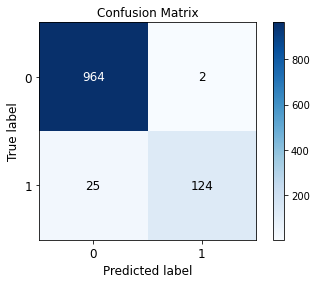

In [18]:
dl_pipeline.evaluate_model(fasttext_nn_model, X_test, y_test)

#### Plot Accuracy and Loss

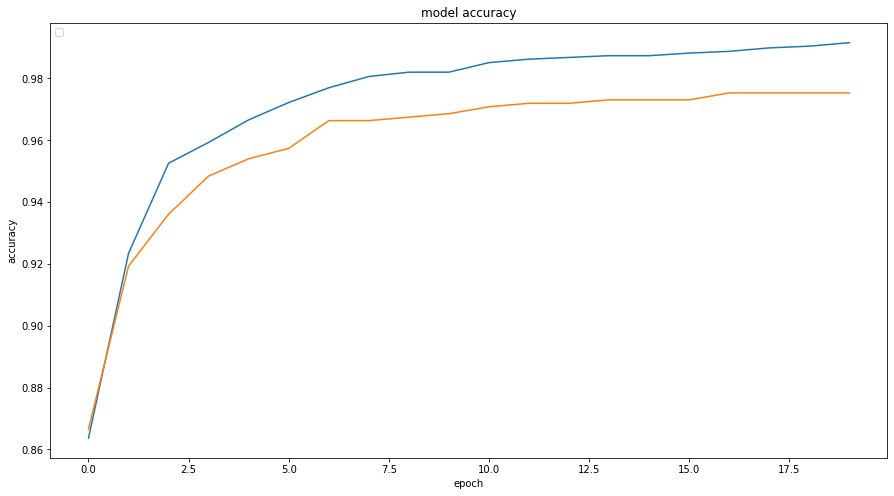

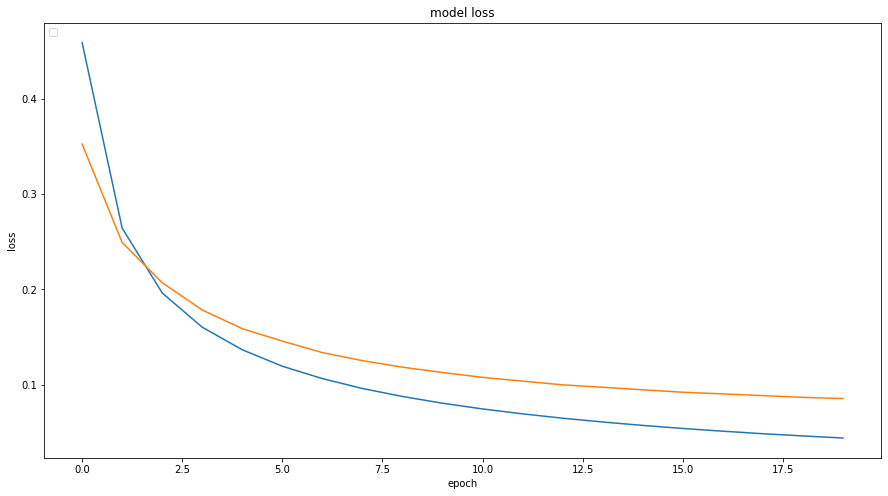

In [19]:
dl_pipeline.plot_accuracy_loss(history)

### LSTM
Let us create an LSTM model with the embeddings from Fasttext.

In [20]:
embedding_dim = 300
lstm_units = 128
fasttext_lstm_model = dl_pipeline.create_LSTM_nn_model(embedding_matrix, vocab_size, max_len, embedding_dim)

In [21]:
fasttext_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          2306700   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,526,477
Trainable params: 219,777
Non-trainable params: 2,306,700
_________________________________________________________________


In [22]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(fasttext_lstm_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
28/28 [==============================] - 5s 33ms/step - loss: 0.4754 - acc: 0.8687 - val_loss: 0.4345 - val_acc: 0.8430
Epoch 2/20
28/28 [==============================] - 0s 12ms/step - loss: 0.3433 - acc: 0.8712 - val_loss: 0.3102 - val_acc: 0.8430
Epoch 3/20
28/28 [==============================] - 0s 12ms/step - loss: 0.1919 - acc: 0.9077 - val_loss: 0.1861 - val_acc: 0.9686
Epoch 4/20
28/28 [==============================] - 0s 12ms/step - loss: 0.1524 - acc: 0.9644 - val_loss: 0.1555 - val_acc: 0.9630
Epoch 5/20
28/28 [==============================] - 0s 12ms/step - loss: 0.1408 - acc: 0.9624 - val_loss: 0.1566 - val_acc: 0.9619
Epoch 6/20
28/28 [==============================] - 0s 12ms/step - loss: 0.1727 - acc: 0.9557 - val_loss: 0.4075 - val_acc: 0.8834
Epoch 7/20
28/28 [==============================] - 0s 13ms/step - loss: 0.3726 - acc: 0.8816 - val_loss: 0.4183 - val_acc: 0.8576
Epoch 8/20
28/28 [==============================] - 0s 12ms/step - loss: 0.3622 - a

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score
*AUC ROC Score

18/18 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       966
           1       0.93      0.87      0.90       149

    accuracy                           0.97      1115
   macro avg       0.96      0.93      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Model ROC-AUC score for test sample: 0.982


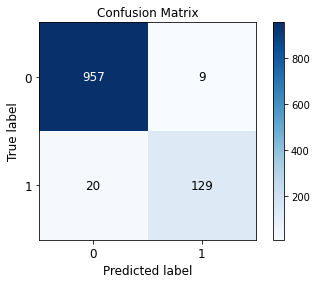

In [23]:
dl_pipeline.evaluate_model(fasttext_lstm_model, X_test, y_test)

### Plot Accuracy and Loss

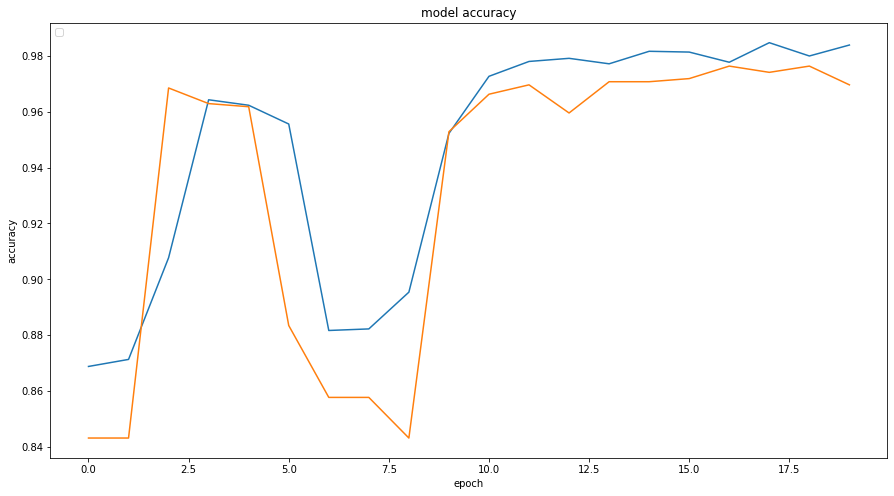

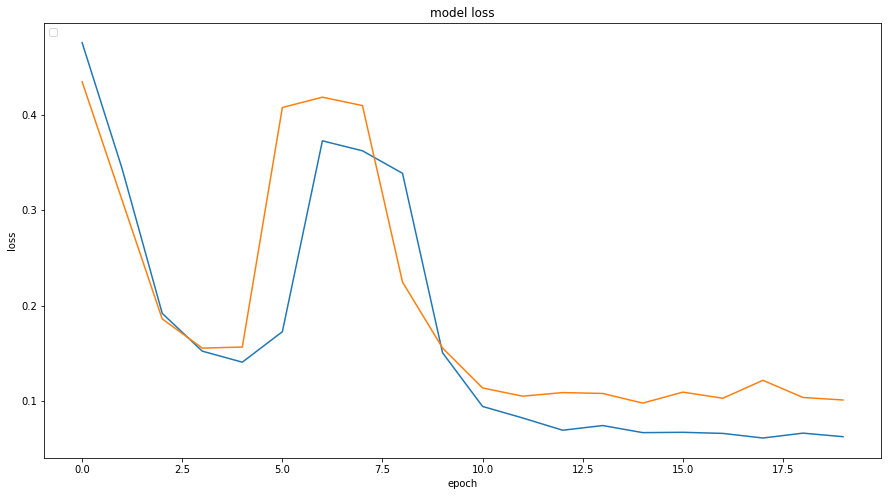

In [24]:
dl_pipeline.plot_accuracy_loss(history)

### BiLSTM
Let us create an BiLSTM model with the embeddings from Fasttext.

In [25]:
embedding_dim = 300
lstm_units = 128
fasttext_bilstm_model = dl_pipeline.create_BiLSTM_nn_model(embedding_matrix, vocab_size, max_len, embedding_dim)

In [26]:
fasttext_bilstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          2306700   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,746,253
Trainable params: 439,553
Non-trainable params: 2,306,700
_________________________________________________________________


In [27]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(fasttext_bilstm_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
28/28 [==============================] - 4s 54ms/step - loss: 0.3630 - acc: 0.8547 - val_loss: 0.2082 - val_acc: 0.9271
Epoch 2/20
28/28 [==============================] - 1s 21ms/step - loss: 0.1033 - acc: 0.9652 - val_loss: 0.1110 - val_acc: 0.9675
Epoch 3/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0801 - acc: 0.9770 - val_loss: 0.0993 - val_acc: 0.9753
Epoch 4/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0554 - acc: 0.9829 - val_loss: 0.0788 - val_acc: 0.9709
Epoch 5/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0491 - acc: 0.9840 - val_loss: 0.0764 - val_acc: 0.9753
Epoch 6/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0492 - acc: 0.9840 - val_loss: 0.0648 - val_acc: 0.9832
Epoch 7/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0478 - acc: 0.9857 - val_loss: 0.0672 - val_acc: 0.9854
Epoch 8/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0369 - a

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score
*AUC ROC Score

18/18 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.99      0.93      0.96       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

Model ROC-AUC score for test sample: 0.985


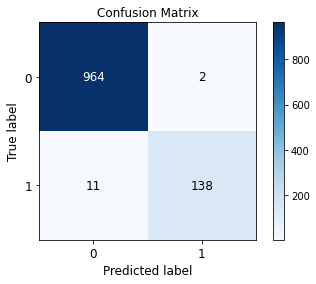

In [28]:
dl_pipeline.evaluate_model(fasttext_bilstm_model, X_test, y_test)

### Plot Accuracy and Loss

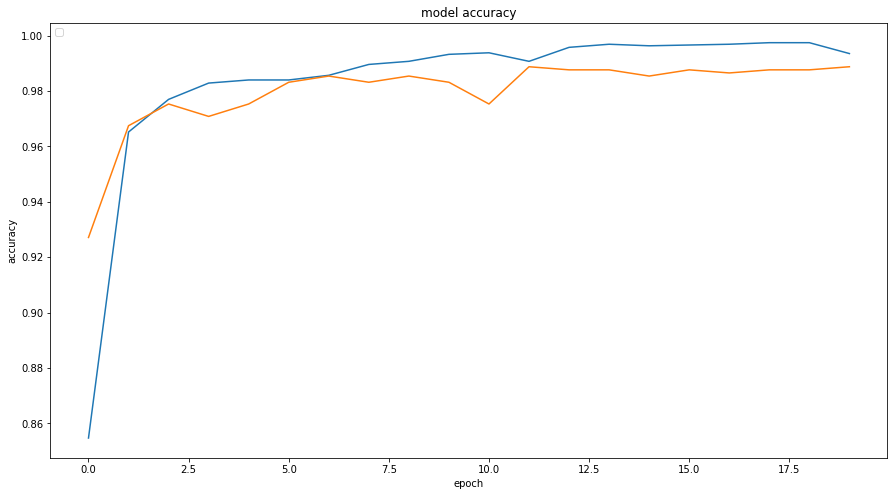

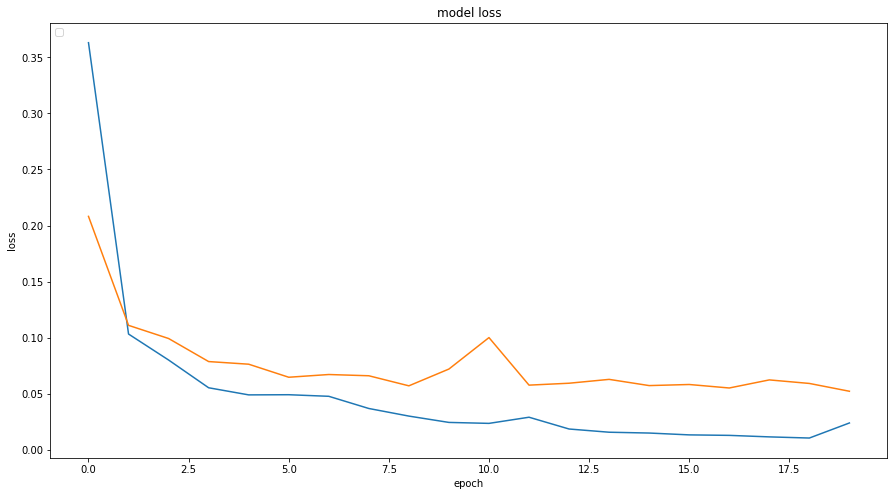

In [29]:
dl_pipeline.plot_accuracy_loss(history)

## BiLSTM with Attention
Let us create a BiLSTM model with Attention layer and the embeddings from Fasttext.

In [30]:
lstm_units = 128
fasttext_bilstm_attention_model = dl_pipeline.create_BiLSTM_Attention_nn_model(lstm_units, embedding_matrix, vocab_size, max_len, embedding_dim)

In [31]:
fasttext_bilstm_attention_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 100, 300)          2306700   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 attention (attention)       (None, 256)               356       
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,746,609
Trainable params: 439,909
Non-trainable params: 2,306,700
_____________________________________________

### Train model
I have experimented with different hyperparameters:
* epochs
*batch_size
* Number of hidden units

In [32]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(fasttext_bilstm_attention_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
28/28 [==============================] - 5s 59ms/step - loss: 0.4369 - acc: 0.8589 - val_loss: 0.2514 - val_acc: 0.9238
Epoch 2/20
28/28 [==============================] - 1s 23ms/step - loss: 0.1937 - acc: 0.9330 - val_loss: 0.1303 - val_acc: 0.9574
Epoch 3/20
28/28 [==============================] - 1s 23ms/step - loss: 0.0921 - acc: 0.9652 - val_loss: 0.1072 - val_acc: 0.9675
Epoch 4/20
28/28 [==============================] - 1s 23ms/step - loss: 0.0618 - acc: 0.9792 - val_loss: 0.0796 - val_acc: 0.9686
Epoch 5/20
28/28 [==============================] - 1s 23ms/step - loss: 0.0556 - acc: 0.9820 - val_loss: 0.0821 - val_acc: 0.9709
Epoch 6/20
28/28 [==============================] - 1s 23ms/step - loss: 0.0439 - acc: 0.9877 - val_loss: 0.0700 - val_acc: 0.9765
Epoch 7/20
28/28 [==============================] - 1s 23ms/step - loss: 0.0408 - acc: 0.9857 - val_loss: 0.0992 - val_acc: 0.9652
Epoch 8/20
28/28 [==============================] - 1s 22ms/step - loss: 0.0459 - a

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score
*AUC ROC Score

18/18 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Model ROC-AUC score for test sample: 0.986


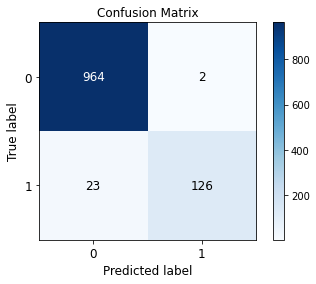

In [33]:
dl_pipeline.evaluate_model(fasttext_bilstm_attention_model, X_test, y_test)

### Plot Accuracy and Loss


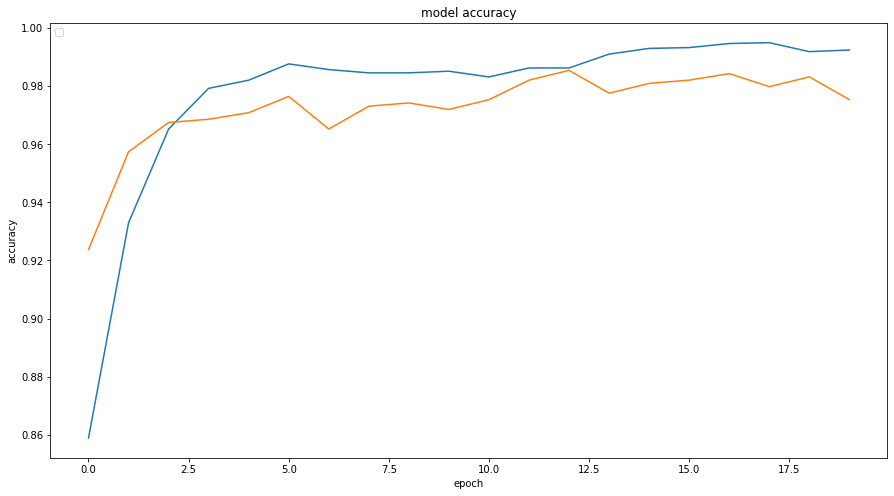

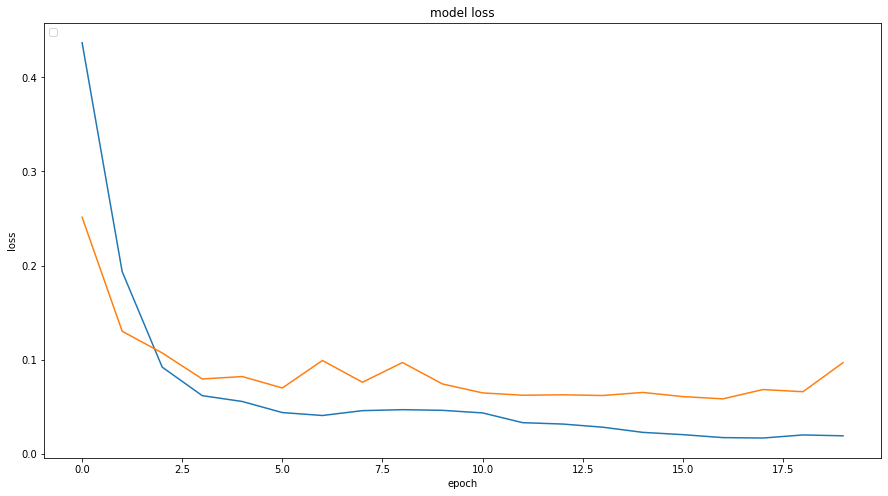

In [34]:
dl_pipeline.plot_accuracy_loss(history)

# Simple Neural Network with Word2Vec

### Loading Word2Vec Vectors

Let us load the pretrained Word2Vec embeddings in a dictionary.

In [11]:
root = "/content/drive/MyDrive/"
w2vec_file_name = 'GoogleNews-vectors-negative300.bin'

w2vec_embedding_dict = dl_pipeline.load_w2vec_embedding_dictionary(root, w2vec_file_name)

2022-06-24 23:15:05,623 : INFO : loading projection weights from /content/drive/MyDrive/GoogleNews-vectors-negative300.bin


Loading word2vec model


2022-06-24 23:16:00,144 : INFO : loaded (3000000, 300) matrix from /content/drive/MyDrive/GoogleNews-vectors-negative300.bin


### Creating Embedding Matrix
We will create an embedding matrix from the Word2Vec vectors that will be used as weights in the embedding layer of our neural networks.

In [12]:
embedding_dim = 300
embedding_matrix = dl_pipeline.create_embedding_matrix(tokenizer, w2vec_embedding_dict, vocab_size, embedding_dim)

## Neural Network
Let us create a simple neural network model with the embeddings from Word2Vec.

In [17]:
embedding_dim = 300
lstm_units = 128
w2vec_nn_model = dl_pipeline.create_simple_nn_model(embedding_matrix, vocab_size, max_len, embedding_dim)

In [21]:
w2vec_nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          2306700   
                                                                 
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 1)                 30001     
                                                                 
Total params: 2,336,701
Trainable params: 30,001
Non-trainable params: 2,306,700
_________________________________________________________________


In [18]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(w2vec_nn_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
28/28 [==============================] - 4s 14ms/step - loss: 0.4310 - acc: 0.8637 - val_loss: 0.3226 - val_acc: 0.8576
Epoch 2/20
28/28 [==============================] - 0s 5ms/step - loss: 0.2274 - acc: 0.9374 - val_loss: 0.2175 - val_acc: 0.9339
Epoch 3/20
28/28 [==============================] - 0s 4ms/step - loss: 0.1634 - acc: 0.9590 - val_loss: 0.1802 - val_acc: 0.9428
Epoch 4/20
28/28 [==============================] - 0s 5ms/step - loss: 0.1311 - acc: 0.9697 - val_loss: 0.1566 - val_acc: 0.9529
Epoch 5/20
28/28 [==============================] - 0s 4ms/step - loss: 0.1107 - acc: 0.9759 - val_loss: 0.1424 - val_acc: 0.9585
Epoch 6/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0965 - acc: 0.9776 - val_loss: 0.1320 - val_acc: 0.9630
Epoch 7/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0856 - acc: 0.9801 - val_loss: 0.1232 - val_acc: 0.9641
Epoch 8/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0769 - acc: 0.9

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score
*AUC ROC Score

18/18 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.94      0.83      0.88       149

    accuracy                           0.97      1115
   macro avg       0.96      0.91      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Model ROC-AUC score for test sample: 0.985


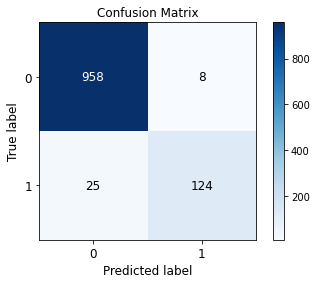

In [19]:
dl_pipeline.evaluate_model(w2vec_nn_model, X_test, y_test)

### Plot Accuracy and Loss

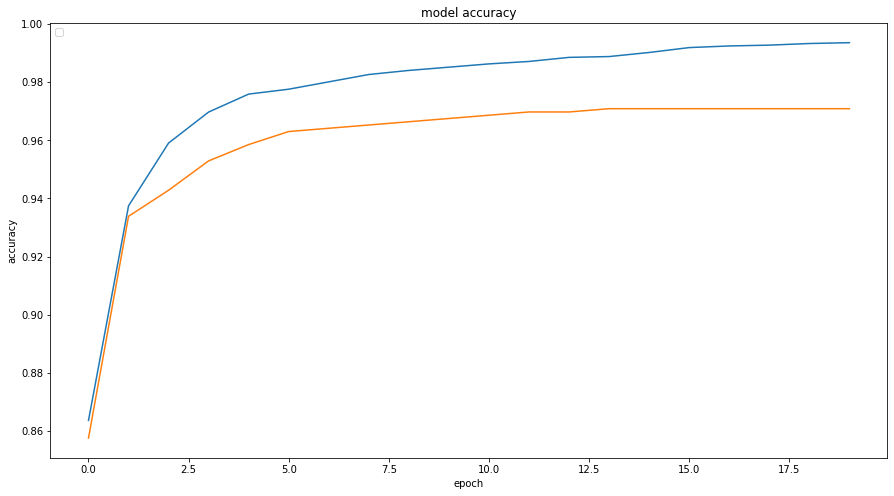

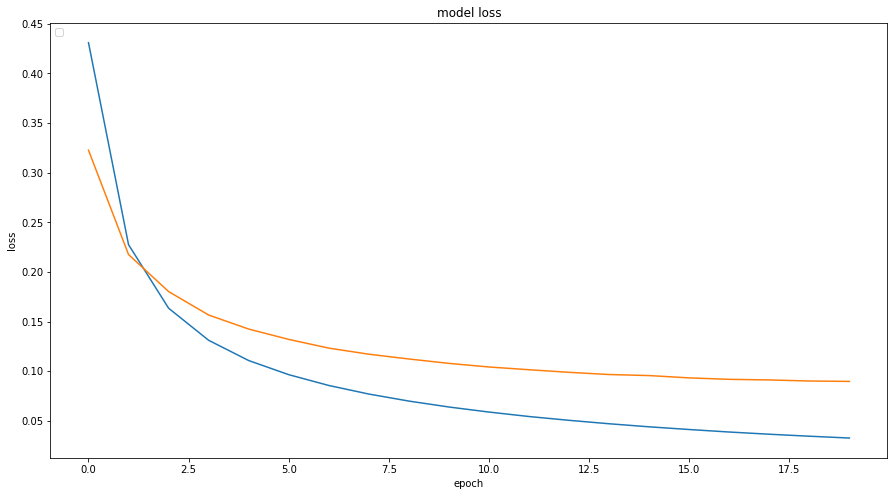

In [20]:
dl_pipeline.plot_accuracy_loss(history)

## LSTM
Let us create an LSTM model with the embeddings from Fasttext.

In [20]:
embedding_dim = 300
lstm_units = 128
w2vec_lstm_model = dl_pipeline.create_LSTM_nn_model(embedding_matrix, vocab_size, max_len, embedding_dim)

In [14]:
w2vec_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          2306700   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,526,477
Trainable params: 219,777
Non-trainable params: 2,306,700
_________________________________________________________________


In [21]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(w2vec_lstm_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
28/28 [==============================] - 3s 33ms/step - loss: 0.4184 - acc: 0.8760 - val_loss: 0.1624 - val_acc: 0.9529
Epoch 2/20
28/28 [==============================] - 0s 12ms/step - loss: 0.1622 - acc: 0.9582 - val_loss: 0.1660 - val_acc: 0.9608
Epoch 3/20
28/28 [==============================] - 0s 14ms/step - loss: 0.1303 - acc: 0.9568 - val_loss: 0.1378 - val_acc: 0.9417
Epoch 4/20
28/28 [==============================] - 0s 12ms/step - loss: 0.1008 - acc: 0.9697 - val_loss: 0.0999 - val_acc: 0.9787
Epoch 5/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0994 - acc: 0.9745 - val_loss: 0.1321 - val_acc: 0.9731
Epoch 6/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0856 - acc: 0.9792 - val_loss: 0.0764 - val_acc: 0.9776
Epoch 7/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0674 - acc: 0.9832 - val_loss: 0.0940 - val_acc: 0.9798
Epoch 8/20
28/28 [==============================] - 0s 13ms/step - loss: 0.0547 - a

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score
*AUC ROC Score

18/18 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Model ROC-AUC score for test sample: 0.988


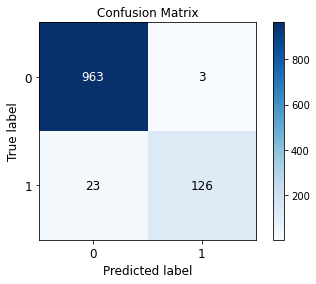

In [22]:
dl_pipeline.evaluate_model(w2vec_lstm_model, X_test, y_test)

### Plot Accuracy and Loss

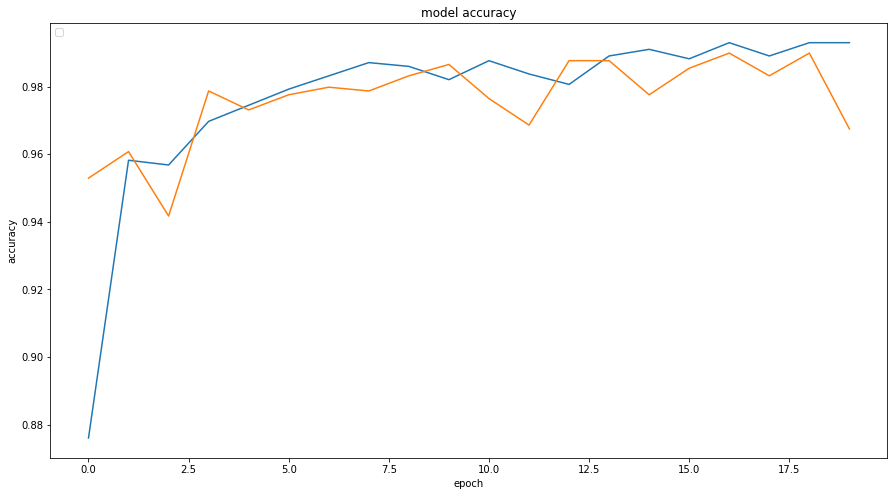

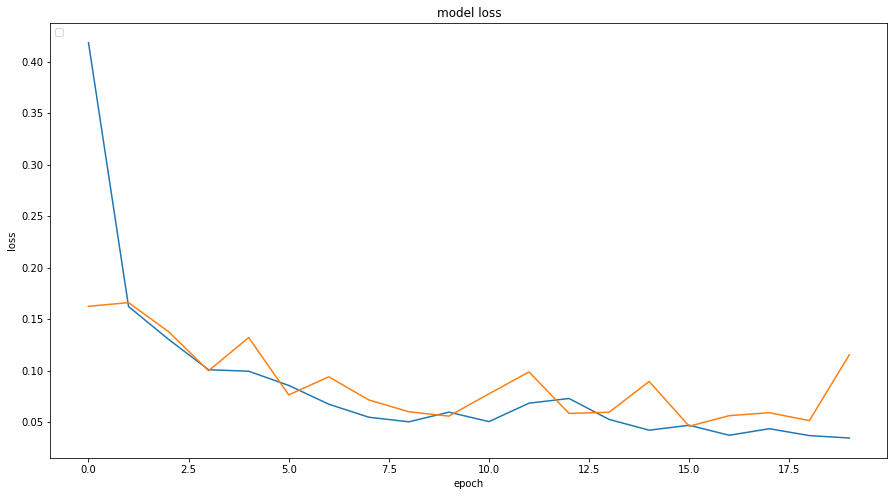

In [23]:
dl_pipeline.plot_accuracy_loss(history)

### BiLSTM
Let us create an BiLSTM model with the embeddings from Fasttext.

In [26]:
embedding_dim = 300
lstm_units = 128
w2vec_bilstm_model = dl_pipeline.create_BiLSTM_nn_model(embedding_matrix, vocab_size, max_len, embedding_dim)

In [27]:
w2vec_bilstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          2306700   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,746,253
Trainable params: 439,553
Non-trainable params: 2,306,700
_________________________________________________________________


In [28]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(w2vec_bilstm_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
28/28 [==============================] - 4s 53ms/step - loss: 0.3693 - acc: 0.8575 - val_loss: 0.1878 - val_acc: 0.9316
Epoch 2/20
28/28 [==============================] - 1s 21ms/step - loss: 0.1675 - acc: 0.9475 - val_loss: 0.1935 - val_acc: 0.9428
Epoch 3/20
28/28 [==============================] - 1s 21ms/step - loss: 0.1054 - acc: 0.9666 - val_loss: 0.1391 - val_acc: 0.9596
Epoch 4/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0750 - acc: 0.9762 - val_loss: 0.0991 - val_acc: 0.9664
Epoch 5/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0646 - acc: 0.9787 - val_loss: 0.1052 - val_acc: 0.9675
Epoch 6/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0567 - acc: 0.9826 - val_loss: 0.0856 - val_acc: 0.9720
Epoch 7/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0527 - acc: 0.9843 - val_loss: 0.0810 - val_acc: 0.9720
Epoch 8/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0482 - a

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score
*AUC ROC Score

18/18 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.98      0.91      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115

Model ROC-AUC score for test sample: 0.989


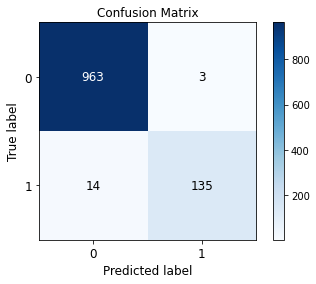

In [29]:
dl_pipeline.evaluate_model(w2vec_bilstm_model, X_test, y_test)

### Plot Accuracy and Loss

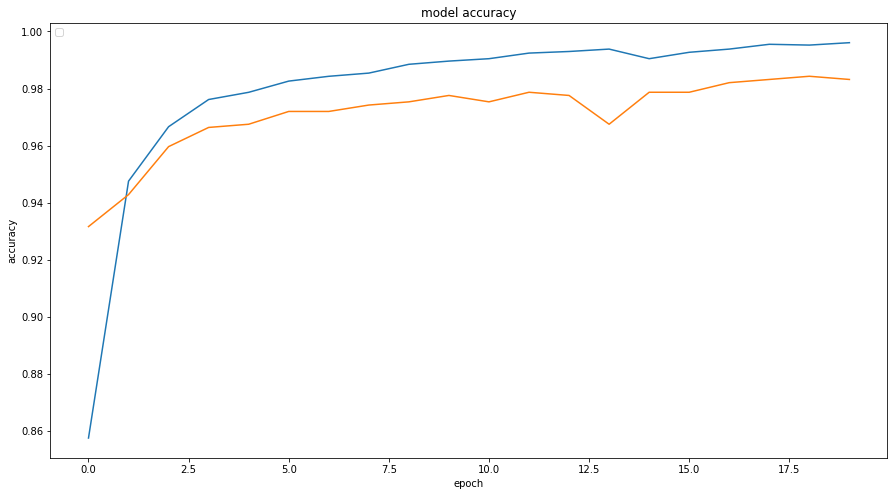

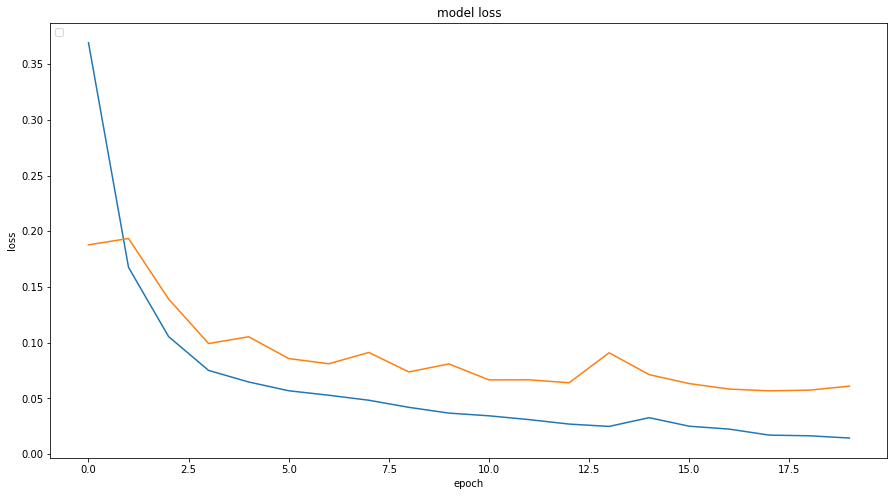

In [30]:
dl_pipeline.plot_accuracy_loss(history)

## BiLSTM with Attention
Let us create a BiLSTM model with Attention layer and the embeddings from Fasttext.

In [31]:
lstm_units = 128
w2vec_bilstm_attention_model = dl_pipeline.create_BiLSTM_Attention_nn_model(lstm_units, embedding_matrix, vocab_size, max_len, embedding_dim)

In [32]:
w2vec_bilstm_attention_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 100, 300)          2306700   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 attention (attention)       (None, 256)               356       
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,746,609
Trainable params: 439,909
Non-trainable params: 2,306,700
_____________________________________________

### Train model
I have experimented with different hyperparameters:
* epochs
*batch_size
* Number of hidden units

In [33]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(w2vec_bilstm_attention_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
28/28 [==============================] - 5s 56ms/step - loss: 0.4460 - acc: 0.8676 - val_loss: 0.3703 - val_acc: 0.8430
Epoch 2/20
28/28 [==============================] - 1s 23ms/step - loss: 0.2031 - acc: 0.9304 - val_loss: 0.1800 - val_acc: 0.9361
Epoch 3/20
28/28 [==============================] - 1s 23ms/step - loss: 0.1072 - acc: 0.9610 - val_loss: 0.0959 - val_acc: 0.9664
Epoch 4/20
28/28 [==============================] - 1s 23ms/step - loss: 0.0698 - acc: 0.9770 - val_loss: 0.0895 - val_acc: 0.9652
Epoch 5/20
28/28 [==============================] - 1s 23ms/step - loss: 0.0783 - acc: 0.9748 - val_loss: 0.0758 - val_acc: 0.9731
Epoch 6/20
28/28 [==============================] - 1s 23ms/step - loss: 0.0661 - acc: 0.9790 - val_loss: 0.0623 - val_acc: 0.9809
Epoch 7/20
28/28 [==============================] - 1s 23ms/step - loss: 0.0476 - acc: 0.9857 - val_loss: 0.0681 - val_acc: 0.9765
Epoch 8/20
28/28 [==============================] - 1s 23ms/step - loss: 0.0397 - a

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score
*AUC ROC Score

18/18 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Model ROC-AUC score for test sample: 0.981


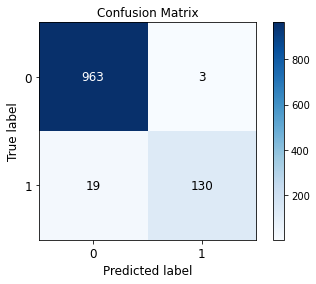

In [34]:
dl_pipeline.evaluate_model(w2vec_bilstm_attention_model, X_test, y_test)

### Plot Accuracy and Loss


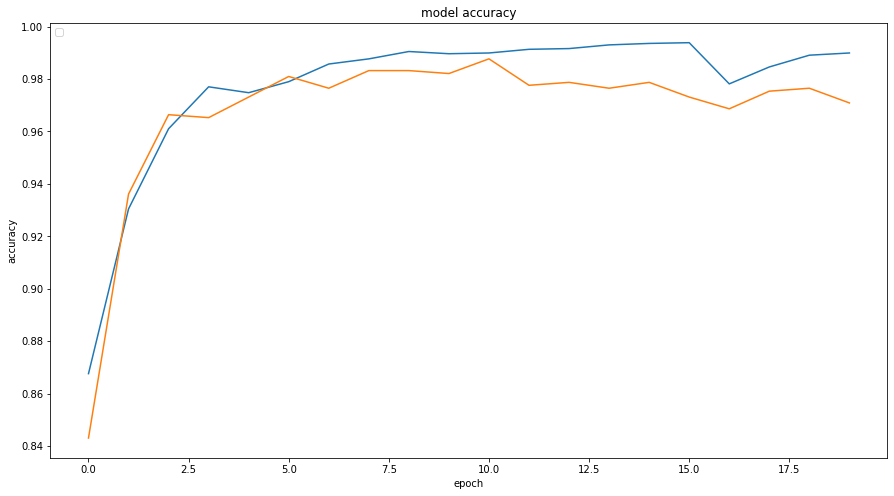

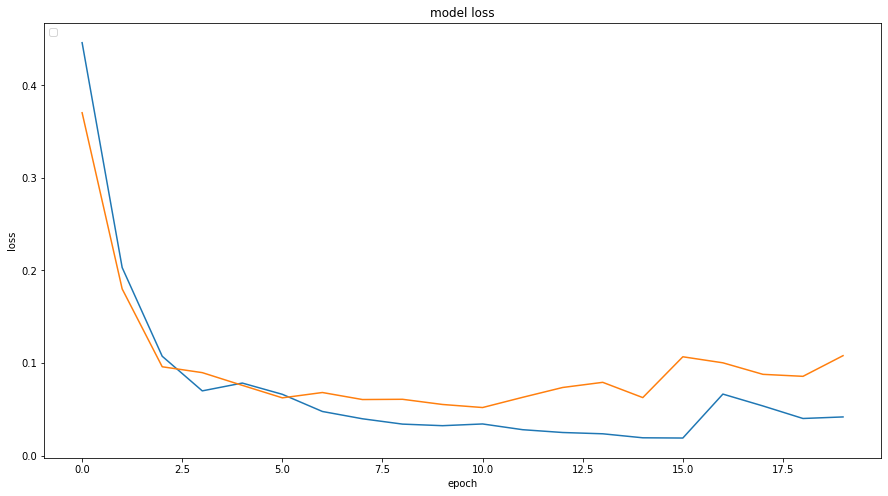

In [35]:
dl_pipeline.plot_accuracy_loss(history)

# Model Comparison

These are the model performance metrics for different models with different embedding vectors. As the classification problem is imbalanced, we should also look at metrics like Precision, Recall, AUC ROC etc, apart from accuracy.

**GloVe Embeddings:**

|                       | Accuracy | Weighted Avg Precision | Weighted Avg Recall | Weighted Avg  F1-Score | AUC ROC Score |
|-----------------------|----------|------------------------|---------------------|------------------------|---------------|
| Neural Network        | 0.97     | 0.97                   | 0.97                | 0.97                   | 0.982         |
| LSTM                  | 0.98     | 0.98                   | 0.98                | 0.98                   | 0.988         |
| BiLSTM                | 0.98     | 0.98                   | 0.98                | 0.98                   | 0.992         |
| BiLSTM with Attention | 0.98     | 0.98                   | 0.98                | 0.98                   | 0.986         |

**FastText Embeddings:**

|                       | Accuracy | Weighted Avg Precision | Weighted Avg Recall | Weighted Avg  F1-Score | AUC ROC Score |
|-----------------------|----------|------------------------|---------------------|------------------------|---------------|
| Neural Network        | 0.98     | 0.98                   | 0.98                | 0.97                   | 0.977         |
| LSTM                  | 0.97     | 0.97                   | 0.97                | 0.97                   | 0.982         |
| BiLSTM                | 0.99     | 0.99                   | 0.99                | 0.99                   | 0.985         |
| BiLSTM with Attention | 0.98     | 0.98                   | 0.98                | 0.98                   | 0.986         |

**Word2Vec Embeddings:**

|                       | Accuracy | Weighted Avg Precision | Weighted Avg Recall | Weighted Avg  F1-Score | AUC ROC Score |
|-----------------------|----------|------------------------|---------------------|------------------------|---------------|
| Neural Network        | 0.97     | 0.97                   | 0.97                | 0.97                   | 0.985         |
| LSTM                  | 0.98     | 0.98                   | 0.98                | 0.98                   | 0.988         |
| BiLSTM                | 0.98     | 0.98                   | 0.98                | 0.98                   | 0.989         |
| BiLSTM with Attention | 0.98     | 0.98                   | 0.98                | 0.98                   | 0.981         |


* For almost all models, the metrics improve as we go from NN > LSTM > BiLSTM > BiLSTM with Attention
* All Embedding methods perform quite well, with Glove embeddings giving best performance with BiLSTM
* FastText + BiLSTM has accuracy 0.99 and 0.985 AUC ROC, 0.9 F1 score
* Glove + BiLSTM has similar competitive performance, but it misclassifies more Not Spam as Spam than Fasttext, which is not desired, so Fasttext + BiLSTM is better.

#Productionising Model


The Classification model that we have trained for detecting spam and not spam can be implemented as a **microservice**. 

The trained model will be saved, along with the weights and loaded when the microservice is started.

The model will be deployed on a server, and since it is a spam detection model, it will be **invoked automatically** everytime a new text/email is received in the inbox of users.

The microservice will also be responsible to **preprocess the new input** in the format required by the model, eg tokenization etc

***Model input:*** Text to be classified as Spam/Not Spam

The microservice API can be implemented using:
 * *Flask*
 * *Connexion* (Flask +Swagger)

To test the deployed model, *Postman* can be used with different text inputs.

Another way to productionize the model could be to build a small web app. This can be done using *Streamlit* or other web app libraries. 

Finally, to make sure the service is portable and independent of OS and other dependencies, it can be converted to a **Docker** container. Having a Docker container will make it easier to maintain and refresh our models, if we make some training technique changes, architecture changes and want to deploy a retrained model.

To make sure that our API can handle large number of requests, we can consider Cloud solutions like **AWS** and **Kubernetes**.